# PolyBeam Tutorial

Create a PolyBeam that is rotated and elliptical (using the PerturbedPolyBeam sub-class). Plot the beam by l,m co-ordinates. Run simulations rotating the beam by 0 ... 180 degrees, to show that the antenna signal changes as a single source is viewed through the beam.

### Functions to setup observing configuration, beam,  and simulation

Note the perturbed_poly_beam function below - this demonstrates creating a PerturbedPolyBeam.

In [1]:
from hera_sim.visibilities import VisCPU
from hera_sim.beams import PerturbedPolyBeam
from hera_sim import io
import numpy as np
import matplotlib.pyplot as plt

np.seterr(invalid="ignore")


def antennas():
    """
    Two random antennas.
    """
    locs = [[ 308, 253, 0.49],
                    [8, 299, 0.22]]

    ants = {}
    for i in range(len(locs)):
        ants[i] = ( locs[i][0], locs[i][1], locs[i][2] )

    return ants

def sources():
    """
    A single source placed off-zenith at the time of observation.
    """
    sources = np.array([ [ 128, -29, 4, 0, ] ])
    ra_dec = sources[:, :2]
    flux = sources[:, 2]
    spectral_index = sources[:, 3]

    ra_dec = np.deg2rad(ra_dec)

    return ra_dec, flux, spectral_index


def perturbed_poly_beam(rotation):
    """
    Elliptical rotated PolyBeam.
    """
    
    # Typical parameters. The beam_coeffs are set so that the beam approximates
    # the Fagnoni beam. Parameters are desribed in class docstrings.
    cfg_beam = dict(ref_freq=1.e8,
        spectral_index =        -0.6975,
        perturb =               True,
        mainlobe_width =        0.3 ,
        nmodes=                8,
        beam_coeffs=[ 0.29778665, -0.44821433, 0.27338272,
                    -0.10030698, -0.01195859, 0.06063853,
                    -0.04593295,  0.0107879,  0.01390283,
                    -0.01881641, -0.00177106, 0.01265177,
                    -0.00568299, -0.00333975, 0.00452368,
                     0.00151808, -0.00593812, 0.00351559
                    ] )

    # The key parameters here are xstretch, ystretch, and rotation, which
    # form the elliptical rotated beam.
    return PerturbedPolyBeam(perturb_coeff=np.array([-0.20437532, -0.4864951,
                    -0.18577532, -0.38053642,  0.08897764,  0.06367166,
                    0.29634711,  1.40277112]),
                mainlobe_scale=1.0, xstretch=1.1, ystretch=0.8, rotation=rotation, **cfg_beam)


def run_sim(beam_rotation, use_pixel_beams=True):
    """
    Run a simple sim using hera_sim. 
    
    use_pixel_beams: bool
        The beam may be pixeled, or not pixelized. In the first case, spline 
        interpolation is used to obtain a beam value for an l,m source location. 
        In the latter case, the interp() method of the beam is called using 
        source azimuth and zenith angle; this produces a more accurate beam value.
    """

    ants = antennas()

    # Observing parameters in a UVData object.
    uvdata = io.empty_uvdata(
        nfreq = 1,
        start_freq = 100000000.0,
        channel_width = 97000.0,
        start_time = 2458902.4,
        integration_time = 40,
        ntimes = 1,
        ants = ants
    )

    # Get source location, flux, beam.
    freqs = np.unique(uvdata.freq_array)

    ra_dec, flux, spectral_index = sources()
    
    beams = [ perturbed_poly_beam(beam_rotation) for i in range(len(ants.keys())) ]

    # calculate source fluxes for hera_sim use.
    flux = (freqs[:, np.newaxis]/freqs[0])**spectral_index*flux

    # Run the hera_sim simulation.
    simulator = VisCPU(
        uvdata = uvdata,
        beams = beams,
        beam_ids = list(ants.keys()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        use_pixel_beams = use_pixel_beams,
        bm_pix = 200,
        precision = 2
    )

    simulator.simulate()

    # For testing purposes, extract the autocorrelation of antenna 0.
    # The effect of the beam is to change amplitudes, not phases (in
    # this simulation).
    auto_val = np.abs(simulator.uvdata.get_data(0, 0, "XX")[0][0])

    return auto_val



/users/hgarsden/anaconda3_herasim/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/users/hgarsden/anaconda3_herasim/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/users/hgarsden/anaconda3_herasim/lib/python3.7/site-packages/hera_sim/__init__.py:37: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such th

### Plot an elliptical, rotated, PolyBeam

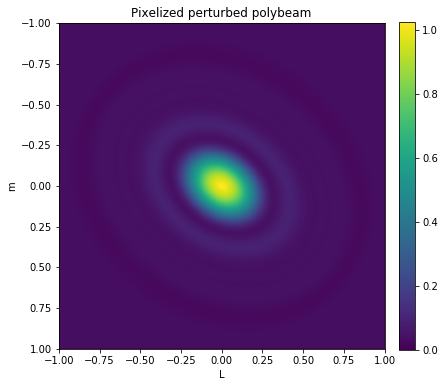

In [2]:
# Pixelize the beam as would be done by hera_sim if use_pixel_beams=True.

beam = perturbed_poly_beam(36)
n_pix_lm = 1001
freqs = np.array([ 100e6 ])
L = np.linspace(-1, 1, n_pix_lm, dtype=np.float32)
L, m = np.meshgrid(L, L)
L = L.flatten()
m = m.flatten()

lsqr = L ** 2 + m ** 2
n = np.where(lsqr < 1, np.sqrt(1 - lsqr), 0)

# Generate azimuth and zenith angle.
az = -np.arctan2(m, L)
za = np.pi/2 - np.arcsin(n)

# Call the beam to get values.
efield_beam = beam.interp(az, za, freqs)[0]
efieldXX = efield_beam[0, 0, 1, 0]

# Regrid and establish values for plotting.
grid = np.zeros((n_pix_lm+1, n_pix_lm+1))
L = L*n_pix_lm/2+n_pix_lm/2
m = m*n_pix_lm/2+n_pix_lm/2
for i in range(len(L)):
    grid[int(np.trunc(L[i])), int(np.trunc(m[i]))] = efieldXX[i]  # not sophisticated gridding

# Plot
plt.figure(figsize=(6, 6))
plt.xlabel("L")
plt.ylabel("m")
plt.title("Pixelized perturbed polybeam")
plt.imshow(grid.T, extent=[-1, 1, 1, -1])
plt.tight_layout()
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


### Simulate observing the beam at different orientations

Observe a single source through the beam as the beam rotates. The autocorrelation of an antenna should 
change because the beam is not circularly symmetric.

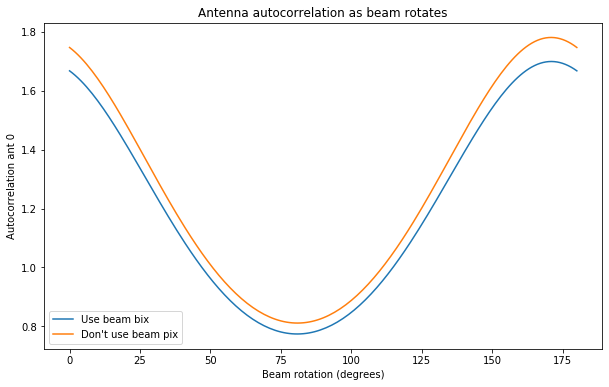

In [3]:
rotations = np.zeros(181)
pix_results = np.zeros(181)
calc_results = np.zeros(181)

# Run simulations with different beam rotations, with/without pixelization of the beam.
for r in range(0, 181):
    pix_result = run_sim(r, use_pixel_beams=True)
    calc_result = run_sim(r, use_pixel_beams=False)     # Direct beam calculation - no pixel beams
    rotations[r] = r
    pix_results[r] = pix_result
    calc_results[r] = calc_result

# Plot an antenna autocorrelation for different rotations, with a separate line for
# pixelixed beams, and another line without pixelized beams. The lines should
# be close to each other and have the same shpe (i.e. the changing beam affects
# both methods of beam interpolation).

plt.figure(figsize=(10, 6))
plt.plot(rotations, pix_results, label="Use beam bix")
plt.plot(rotations, calc_results, label="Don't use beam pix")
plt.xlabel("Beam rotation (degrees)")
plt.ylabel("Autocorrelation ant 0")
plt.title("Antenna autocorrelation as beam rotates")
plt.legend()
plt.show()

The plot shows that the use of pixelized beams produces slightly different values. However, the changing beam
orientation means both lines are similar and change in the same way.